In [1]:
#!unzip /content/Faces.zip

In [2]:
#!unzip /content/Background.zip

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color
import os
from tqdm import tqdm
import joblib
from skimage.transform import resize
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Preparación de los datos

In [4]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [5]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:03<00:00, 3762.10it/s]


In [6]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

In [7]:
P = len(positive_patches)

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
for i in range(31):
    filename = "Background/"+str(i)+".jpg"
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Tamaño de las imágenes de rostros
size = positive_patches[0].shape
print(f'Image size: {size}')

Image size: (64, 64)


In [10]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [11]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 40/40 [00:01<00:00, 39.76it/s]


(12800, 64, 64)

In [12]:
N = len(negative_patches)

In [13]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 25633it [00:12, 2003.17it/s]


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(20506, 2916)

In [16]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [17]:
# Guardar el scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [18]:
# Apply PCA to extract eigenfaces

pca = PCA(n_components=500, whiten=True).fit(X_train_std)

In [19]:
# Guardar PCA
joblib.dump(pca, 'pca.joblib')

['pca.joblib']

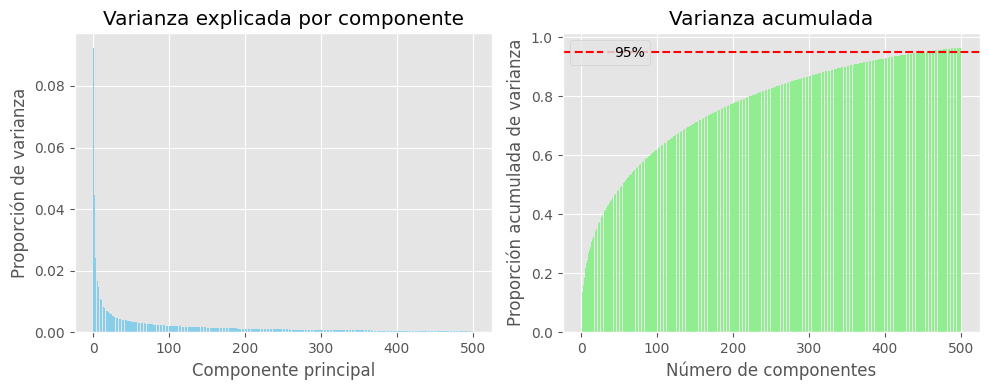

In [20]:
# Obtener varianzas
var_explicada = pca.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Varianza explicada
ax1.bar(range(1, len(var_explicada)+1), var_explicada, color='skyblue')
ax1.set_title('Varianza explicada por componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Proporción de varianza')
ax1.grid(True)

# Varianza acumulada
ax2.bar(range(1, len(var_acumulada)+1), var_acumulada, color='lightgreen')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax2.set_title('Varianza acumulada')
ax2.set_xlabel('Número de componentes')
ax2.set_ylabel('Proporción acumulada de varianza')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

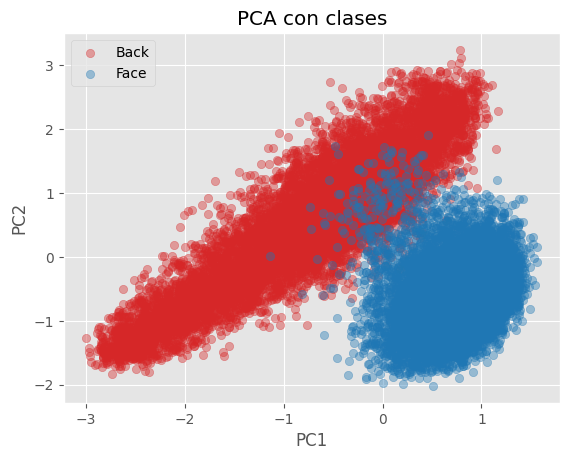

In [21]:
X_train_pca = pca.transform(X_train_std)

# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(X_train_pca[y_train == class_value, 0], X_train_pca[y_train == class_value, 1],
                c=colors[class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

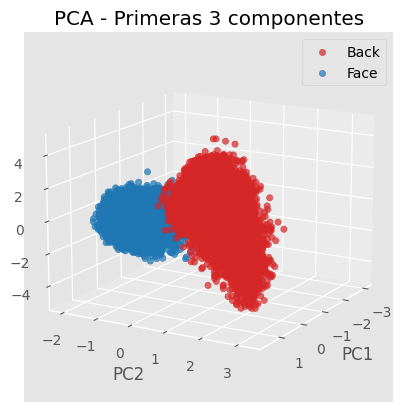

In [22]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    ax.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        X_train_pca[y_train == class_value, 2],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.7
    )

ax.view_init(elev=15, azim=30)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA - Primeras 3 componentes')
ax.legend()
plt.show()

# Clasificador

In [23]:
model = GaussianNB()

In [24]:
model.fit(X_train_pca, y_train)

GaussianNB()

In [25]:
y_train_pred = model.predict(X_train_pca)

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93     10273
         1.0       0.92      0.94      0.93     10233

    accuracy                           0.93     20506
   macro avg       0.93      0.93      0.93     20506
weighted avg       0.93      0.93      0.93     20506



In [27]:
X_val_std = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_std)

In [28]:
y_val_pred = model.predict(X_val_pca)

In [29]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2527
         1.0       0.93      0.94      0.94      2600

    accuracy                           0.94      5127
   macro avg       0.94      0.94      0.94      5127
weighted avg       0.94      0.94      0.94      5127



In [30]:
# Guardar el modelo
joblib.dump(model, 'modelo_entrenado.joblib')

['modelo_entrenado.joblib']

# Encontrar mejores Hyperparámetros

In [31]:
# Definir el modelo y el espacio de hiperparámetros
param_dist = {
    'var_smoothing': np.logspace(-12, -6, 50)
}

gnb = GaussianNB()
random_search = RandomizedSearchCV(
    gnb,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    scoring='accuracy',
    cv=3,       # Número de folds para cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train_pca, y_train)

print("Mejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor score de validación:", random_search.best_score_)

# Evaluar en test
y_pred = random_search.predict(X_val_pca)
print("Accuracy en test:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Python(67418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END ................var_smoothing=3.906939937054621e-11; total time=   0.3s
[CV] END .................var_smoothing=4.71486636345739e-09; total time=   0.7s
[CV] END ................var_smoothing=5.963623316594637e-08; total time=   0.7s
[CV] END ................var_smoothing=5.963623316594637e-08; total time=   0.8s
[CV] END ................var_smoothing=3.906939937054621e-11; total time=   0.8s
[CV] END ................var_smoothing=5.963623316594637e-08; total time=   0.8s
[CV] END ................var_smoothing=3.906939937054621e-11; total time=   0.8s
[CV] END .................var_smoothing=4.71486636345739e-09; total time=   0.8s
[CV] END .................var_smoothing=3.23745754281764e-07; total time=   0.3s
[CV] END .................var_smoothing=4.71486636345739e-09; total time=   0.3s
[CV] END ...............var_smoothing=1.2067926406393264e-10; total time=   0.3s
[CV] END ................var_smoothing=7.543120063354607e-07; total time=   0.3s
[CV] END .................va

In [35]:
# Definir el modelo y el espacio de hiperparámetros
param_grid = {
    'var_smoothing': sorted(
        list(np.logspace(-12, -6, 20)) +  # valores logarítmicos entre 1e-12 y 1e-6
        [1e-13, 5e-13, 1e-11, 5e-11, 1e-10, 5e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7]  # valores adicionales
    )
}

gnb = GaussianNB()
grid_search = GridSearchCV(
    gnb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,       # Número de folds para cross-validation
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor score de validación:", grid_search.best_score_)

# Evaluar en test
y_pred = grid_search.predict(X_val_pca)
print("Accuracy en test:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


Python(67887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67889) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END ................................var_smoothing=1e-13; total time=   0.3s
[CV] END ................................var_smoothing=1e-13; total time=   0.3s
[CV] END ................................var_smoothing=1e-13; total time=   0.3s
[CV] END ................................var_smoothing=1e-12; total time=   0.2s
[CV] END .................var_smoothing=2.06913808111479e-12; total time=   0.2s
[CV] END .................var_smoothing=2.06913808111479e-12; total time=   0.2s
[CV] END ................................var_smoothing=5e-13; total time=   0.3s
[CV] END .................var_smoothing=2.06913808111479e-12; total time=   0.2s
[CV] END ................var_smoothing=4.281332398719396e-12; total time=   0.2s
[CV] END ................var_smoothing=4.281332398719396e-12; total time=   0.2s
[CV] END ................var_smoothing=4.281332398719396e-12; total time=   0.2s
[CV] END ................var_smoothing=8.858667904100833e-12; total time=   0.3s
[CV] END ................var